# Real-world Data Wrangling

In this project, we will retrieve and extract data from two different datasets, assess the data programmatically and visually, and implement a cleaning strategy for the data. Then we will combine the data and answer research questions with the datasets.

## 1. Gather data

In this section, we will extract data using two different data gathering methods.

### **1.1.** Problem Statement
This project will explore the relationship between weather data and monthly visitation numbers at Yellowstone National Park for a span of five years (2018 - 2023). We will be using a dataset of historical weather data that shows the mean temperature and precipitation sum for each day during that five year period and a dataset of monthly recreational vistor counts for the same time period. These datasets will allow us to investigate if weather, such as low temperatures or high precipitation, has an effect on the number of visitors that enter Yellowstone.

### **1.2.** Gather at least two datasets using two different data gathering methods

The gathering methods we will use are downloading the data manually and gathering data through accessing an API. 

#### **Dataset 1 - Historical Weather Data for Yellowstone National Park**

Type: API

Method: This dataset was gathered using the API method from https://open-meteo.com/en/docs/historical-weather-api

Dataset variables:

- "date" - date in YYYYMMDD format
- "temperature_2m_mean" - daily mean temperature in Fahrenheit
- "precipitation_sumDaily" - precipitation sum in inches

The following API call gathers historical weather information for the time period 01/01/2018 - 12/31/2023 at the latitude and longitude for Yellowstone National Park (44.5979° N, 110.5612° W). Temperature measurements are in Fahrenheit and precipitation sums are in inches.

In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import requests
from datetime import datetime

import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 44.5979,
	"longitude": -110.584663,
	"start_date": "2018-01-01",
	"end_date": "2023-12-31",
	"daily": ["temperature_2m_mean", "precipitation_sum"],
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch",
	"timezone": "America/Denver"
}
responses = openmeteo.weather_api(url, params=params)

# Process location
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(1).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["precipitation_sum"] = daily_precipitation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
daily_dataframe.head()

Coordinates 44.60456848144531°N -110.63075256347656°E
Elevation 2431.0 m asl
Timezone b'America/Denver' b'MDT'
Timezone difference to GMT+0 -21600 s


,date,temperature_2m_mean,precipitation_sum
0,2018-01-01 06:00:00+00:00,4.567849,0.000000
1,2018-01-02 06:00:00+00:00,0.679099,0.000000
2,2018-01-03 06:00:00+00:00,10.642850,0.003937
3,2018-01-04 06:00:00+00:00,15.285351,0.000000
4,2018-01-05 06:00:00+00:00,18.990349,0.000000


The API pulled in daily data for the specified range, but we are converting it to monthly data in order to compare it to the monthly visitation data provided by Yellowstone National Park.

In [3]:
# Convert date column to month and year
daily_dataframe['month'] = daily_dataframe['date'].dt.month
daily_dataframe['year'] = daily_dataframe['date'].dt.year

# Group by month and year to calculate mean temperature and mean precipitation
monthly_data = daily_dataframe.groupby(['year', 'month']).agg({
    'temperature_2m_mean': 'mean',
    'precipitation_sum': 'mean'
}).reset_index()

# Print the resulting monthly DataFrame
monthly_data.head()

,year,month,temperature_2m_mean,precipitation_sum
0,2018,1,17.576721,0.080137
1,2018,2,14.309546,0.106862
2,2018,3,21.495472,0.081407
3,2018,4,30.213100,0.105249
4,2018,5,39.777809,0.109220


#### Dataset 2 - Yellowstone National Park Visitation

Type: CSV File 'YNPVisitation by Month.csv"

Method: This file was manually downloaded from https://irma.nps.gov/Stats/Reports/Park/YELL

Dataset variables:

- "Year" - shows data for 1979 - 2023
- "JAN, FEB, MAR, APR, MAY, JUN, JUL, AUG, SEP, OCT, NOV, DEC" - each column shows the number of recreational visitors for that month
- "AnnualTotal" - sum of all visitors for the year
- "Textbox4" - percentage change in visitation vs previous year

This dataset was chosen since it compiles the desired information and was readily accessible via download directly from the National Park Service.

In [4]:
visitation_data = pd.read_csv('YNPVisitation by Month.csv', header=2)
visitation_data.head()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AnnualTotal,Textbox4
0,2023,"45,709","45,717","30,044","69,247","454,262","847,864","969,692","846,389","838,458","299,127","20,109","34,764","4,501,382",36.8%
1,2022,"46,615","47,300","35,593","80,283","523,680","525,363","596,562","582,211","567,587","236,567","17,687","30,794","3,290,242",-32.3%
2,2021,"35,338","36,897","35,611","67,508","473,799","938,845","1,080,767","921,844","882,078","316,662","33,144","37,749","4,860,242",27.7%
3,2020,"25,234","41,880","32,516",0,"46,219","573,205","955,645","881,829","837,114","359,889","24,132","28,643","3,806,306",-5.3%
4,2019,"33,896","31,650","28,695","48,150","434,385","781,853","936,062","820,006","693,118","171,339","15,628","25,506","4,020,288",-2.3%


## 2. Assess data

We will now assess the data for quality and tidiness.

### Quality Issue 1: Incorrect Data Types

In [5]:
# Inspecting the dataframe visually
visitation_data.head(10)

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AnnualTotal,Textbox4
0,2023,"45,709","45,717","30,044","69,247","454,262","847,864","969,692","846,389","838,458","299,127","20,109","34,764","4,501,382",36.8%
1,2022,"46,615","47,300","35,593","80,283","523,680","525,363","596,562","582,211","567,587","236,567","17,687","30,794","3,290,242",-32.3%
2,2021,"35,338","36,897","35,611","67,508","473,799","938,845","1,080,767","921,844","882,078","316,662","33,144","37,749","4,860,242",27.7%
3,2020,"25,234","41,880","32,516",0,"46,219","573,205","955,645","881,829","837,114","359,889","24,132","28,643","3,806,306",-5.3%
4,2019,"33,896","31,650","28,695","48,150","434,385","781,853","936,062","820,006","693,118","171,339","15,628","25,506","4,020,288",-2.3%
5,2018,"29,179","34,263","22,741","37,766","446,875","810,884","940,563","813,970","724,454","218,076","13,849","22,380","4,115,000",0.0%
6,2017,"29,518","32,275","23,897","45,160","419,635","803,652","962,404","916,166","640,068","211,987","10,468","21,294","4,116,524",-3.3%
7,2016,"30,621","36,327","22,924","59,253","444,630","838,316","995,917","841,036","701,754","242,004","24,710","19,685","4,257,177",3.9%
8,2015,"28,091","34,343","22,989","46,600","386,064","780,768","980,702","854,408","680,213","252,013","11,049","20,470","4,097,710",16.6%
9,2014,"26,778","28,233","18,778","31,356","310,039","669,642","858,856","773,357","571,764","194,804","11,537","18,340","3,513,484",10.2%


In [6]:
# Inspecting the dataframe programmatically
visitation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Year         45 non-null     int64 
 1   JAN          45 non-null     object
 2   FEB          45 non-null     object
 3   MAR          45 non-null     object
 4   APR          45 non-null     object
 5   MAY          45 non-null     object
 6   JUN          45 non-null     object
 7   JUL          45 non-null     object
 8   AUG          45 non-null     object
 9   SEP          45 non-null     object
 10  OCT          45 non-null     object
 11  NOV          45 non-null     object
 12  DEC          45 non-null     object
 13  AnnualTotal  45 non-null     object
 14  Textbox4     44 non-null     object
dtypes: int64(1), object(14)
memory usage: 5.4+ KB


Issue and justification: We can see that all the values other than "Year" are in an object format instead of an integer. This will cause problems later when we are trying to perform analyses on the numbers, or even when performing simple summary statistics such as minimum or maximum values. All of these columns should be converted to integers.

### Quality Issue 2: Missing Value?

In [7]:
# Inspecting the dataframe visually
visitation_data.head(10)

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AnnualTotal,Textbox4
0,2023,"45,709","45,717","30,044","69,247","454,262","847,864","969,692","846,389","838,458","299,127","20,109","34,764","4,501,382",36.8%
1,2022,"46,615","47,300","35,593","80,283","523,680","525,363","596,562","582,211","567,587","236,567","17,687","30,794","3,290,242",-32.3%
2,2021,"35,338","36,897","35,611","67,508","473,799","938,845","1,080,767","921,844","882,078","316,662","33,144","37,749","4,860,242",27.7%
3,2020,"25,234","41,880","32,516",0,"46,219","573,205","955,645","881,829","837,114","359,889","24,132","28,643","3,806,306",-5.3%
4,2019,"33,896","31,650","28,695","48,150","434,385","781,853","936,062","820,006","693,118","171,339","15,628","25,506","4,020,288",-2.3%
5,2018,"29,179","34,263","22,741","37,766","446,875","810,884","940,563","813,970","724,454","218,076","13,849","22,380","4,115,000",0.0%
6,2017,"29,518","32,275","23,897","45,160","419,635","803,652","962,404","916,166","640,068","211,987","10,468","21,294","4,116,524",-3.3%
7,2016,"30,621","36,327","22,924","59,253","444,630","838,316","995,917","841,036","701,754","242,004","24,710","19,685","4,257,177",3.9%
8,2015,"28,091","34,343","22,989","46,600","386,064","780,768","980,702","854,408","680,213","252,013","11,049","20,470","4,097,710",16.6%
9,2014,"26,778","28,233","18,778","31,356","310,039","669,642","858,856","773,357","571,764","194,804","11,537","18,340","3,513,484",10.2%


In [8]:
# Inspecting the dataframe programmatically
visitation_data.eq('0')

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AnnualTotal,Textbox4
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Issue and justification: Upon visually inspecting the data, we see there is a value of 0 for visitors in April 2020. Using .eq shows us that a total of 0 visitors is not True for any other month. More investigation will be needed to see if this is an error or an accurate number. If accurate, we will need to decide how to address this outlier. 

### Tidiness Issue 1: Month Columns Instead of Rows 

In [9]:
#Inspecting the dataframes visually
visitation_data.head()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AnnualTotal,Textbox4
0,2023,"45,709","45,717","30,044","69,247","454,262","847,864","969,692","846,389","838,458","299,127","20,109","34,764","4,501,382",36.8%
1,2022,"46,615","47,300","35,593","80,283","523,680","525,363","596,562","582,211","567,587","236,567","17,687","30,794","3,290,242",-32.3%
2,2021,"35,338","36,897","35,611","67,508","473,799","938,845","1,080,767","921,844","882,078","316,662","33,144","37,749","4,860,242",27.7%
3,2020,"25,234","41,880","32,516",0,"46,219","573,205","955,645","881,829","837,114","359,889","24,132","28,643","3,806,306",-5.3%
4,2019,"33,896","31,650","28,695","48,150","434,385","781,853","936,062","820,006","693,118","171,339","15,628","25,506","4,020,288",-2.3%


In [10]:
#Inspecting the dataframe programmatically
columns = visitation_data.columns.tolist()
print(columns)

['Year', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'AnnualTotal', 'Textbox4']


Issue and justification: The current structure where each month is represented as a separate column violates the principle of tidy data, which states each variable should be a column and each observation should be a row. We need to reshape the data so that there is a 'Month' column, similar to the way our weather data is structured. Using melt(), we can programatically reshape the dataset and verify the results. 

### Tidiness Issue 2:  Month Labels

In [11]:
# Inspecting the dataframe visually
visitation_data.head()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AnnualTotal,Textbox4
0,2023,"45,709","45,717","30,044","69,247","454,262","847,864","969,692","846,389","838,458","299,127","20,109","34,764","4,501,382",36.8%
1,2022,"46,615","47,300","35,593","80,283","523,680","525,363","596,562","582,211","567,587","236,567","17,687","30,794","3,290,242",-32.3%
2,2021,"35,338","36,897","35,611","67,508","473,799","938,845","1,080,767","921,844","882,078","316,662","33,144","37,749","4,860,242",27.7%
3,2020,"25,234","41,880","32,516",0,"46,219","573,205","955,645","881,829","837,114","359,889","24,132","28,643","3,806,306",-5.3%
4,2019,"33,896","31,650","28,695","48,150","434,385","781,853","936,062","820,006","693,118","171,339","15,628","25,506","4,020,288",-2.3%


In [12]:
monthly_data.head()

,year,month,temperature_2m_mean,precipitation_sum
0,2018,1,17.576721,0.080137
1,2018,2,14.309546,0.106862
2,2018,3,21.495472,0.081407
3,2018,4,30.213100,0.105249
4,2018,5,39.777809,0.109220


In [13]:
print(columns)

['Year', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'AnnualTotal', 'Textbox4']


In [14]:
# Inspecting the dataframe programmatically
monthly_data['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

Issue and justification: The way months are labeled in the visitation_data dataframe (JAN...DEC) does not match the way months are labeled in monthly_data (1-12). We need to be consistent in our labeling so that the data can be combined.

## 3. Clean data
We will now clean the data to solve the data quality and tidiness issues found in the assessing step.

In [15]:
# Make copies of the datasets to ensure the raw dataframes 
# are not impacted
copy_visitation_data = visitation_data
copy_monthly_data = monthly_data

### Quality Issue 1: Incorrect Data Types

In [16]:
# Apply the cleaning strategy
# Function to remove commas and convert to integer
def remove_commas_and_convert(column):
    return column.str.replace(',', '').astype(int)

# Exclude 'Year' and the last column
for column in copy_visitation_data.columns[1:-1]: 
    copy_visitation_data[column] = remove_commas_and_convert(copy_visitation_data[column])

In [17]:
copy_visitation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Year         45 non-null     int64 
 1   JAN          45 non-null     int64 
 2   FEB          45 non-null     int64 
 3   MAR          45 non-null     int64 
 4   APR          45 non-null     int64 
 5   MAY          45 non-null     int64 
 6   JUN          45 non-null     int64 
 7   JUL          45 non-null     int64 
 8   AUG          45 non-null     int64 
 9   SEP          45 non-null     int64 
 10  OCT          45 non-null     int64 
 11  NOV          45 non-null     int64 
 12  DEC          45 non-null     int64 
 13  AnnualTotal  45 non-null     int64 
 14  Textbox4     44 non-null     object
dtypes: int64(14), object(1)
memory usage: 5.4+ KB


Justification: All of the monthly visitor totals and the annual totals are now integers. This will allow us to perform analyses on the numbers. 

### **Quality Issue 2: Missing Value?**

In [18]:
# Apply the cleaning strategy
# Filtering the data to include the five years prior to 2020
filtered_data = copy_visitation_data[(copy_visitation_data['Year'] >= 2014) & (copy_visitation_data['Year'] <= 2019)]

# Calculate the average for March, April, and May
average_visitors = filtered_data[['MAR', 'APR', 'MAY']].mean()

# Display the averages
print("Average Visitors for March, April, May (2014-2019):")
print(average_visitors)

Average Visitors for March, April, May (2014-2019):
MAR     23337.333333
APR     44714.166667
MAY    406938.000000
dtype: float64


In [19]:
# Replace the values for March, April, and May 2020 with the calculated averages
copy_visitation_data.loc[copy_visitation_data['Year'] == 2020, 'MAR'] = int(average_visitors['MAR'])
copy_visitation_data.loc[copy_visitation_data['Year'] == 2020, 'APR'] = int(average_visitors['APR'])
copy_visitation_data.loc[copy_visitation_data['Year'] == 2020, 'MAY'] = int(average_visitors['MAY'])

In [20]:
# Validate the cleaning was successful
copy_visitation_data.head(10)

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,AnnualTotal,Textbox4
0,2023,45709,45717,30044,69247,454262,847864,969692,846389,838458,299127,20109,34764,4501382,36.8%
1,2022,46615,47300,35593,80283,523680,525363,596562,582211,567587,236567,17687,30794,3290242,-32.3%
2,2021,35338,36897,35611,67508,473799,938845,1080767,921844,882078,316662,33144,37749,4860242,27.7%
3,2020,25234,41880,23337,44714,406938,573205,955645,881829,837114,359889,24132,28643,3806306,-5.3%
4,2019,33896,31650,28695,48150,434385,781853,936062,820006,693118,171339,15628,25506,4020288,-2.3%
5,2018,29179,34263,22741,37766,446875,810884,940563,813970,724454,218076,13849,22380,4115000,0.0%
6,2017,29518,32275,23897,45160,419635,803652,962404,916166,640068,211987,10468,21294,4116524,-3.3%
7,2016,30621,36327,22924,59253,444630,838316,995917,841036,701754,242004,24710,19685,4257177,3.9%
8,2015,28091,34343,22989,46600,386064,780768,980702,854408,680213,252013,11049,20470,4097710,16.6%
9,2014,26778,28233,18778,31356,310039,669642,858856,773357,571764,194804,11537,18340,3513484,10.2%


Justification: A press release on May 13, 2020 (U.S. Department of the Interior, 2020) indicates that Yellowstone National Park was closed due to the COVID-19 pandemic from March 24, 2020 until May 18, 2020. This is why there are no visitors for the entirety of April 2020. This means the values for March - May 2020 are correct, including the 0 for April. However, the visitation numbers in these months were affected by the pandemic closure, and our analysis seeks to explore the effect of weather on visitation numbers. To remove any skewed values due to the unrelated closure, we replaced the visitation numbers for March - May 2020 with the average visitors from those months for the preceding five years. 

### Tidiness Issue 1: Month Columns Instead of Rows

In [21]:
#Apply the cleaning strategy
copy_visitation_data = pd.melt(copy_visitation_data, id_vars=['Year', 'AnnualTotal', 'Textbox4'], 
                               var_name='Month', value_name='Visitation')

In [22]:
# Validate the cleaning was successful
copy_visitation_data.head()

,Year,AnnualTotal,Textbox4,Month,Visitation
0,2023,4501382,36.8%,JAN,45709
1,2022,3290242,-32.3%,JAN,46615
2,2021,4860242,27.7%,JAN,35338
3,2020,3806306,-5.3%,JAN,25234
4,2019,4020288,-2.3%,JAN,33896


Justification: There is now a "Month" column so that each observation is it's own row. This will make it easier to combine our monthly weather data for analysis. 

### **Tidiness Issue 2: Month Labels**

In [23]:
# Apply the cleaning strategy
# Dictionary for month mapping
month_mapping = {
    '1': 'JAN', '2': 'FEB', '3': 'MAR', '4': 'APR', '5': 'MAY', '6': 'JUN', 
    '7': 'JUL', '8': 'AUG', '9': 'SEP', '10': 'OCT', '11': 'NOV', '12': 'DEC'
}

# Function to replace month numbers with names
def map_month(month):
    return month_mapping.get(str(month), month)

# Apply the mapping to the Month column
copy_monthly_data['month'] = copy_monthly_data['month'].apply(map_month)

In [24]:
# Validate the cleaning was successful
copy_monthly_data['month'].unique()

array(['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP',
       'OCT', 'NOV', 'DEC'], dtype=object)

Justification: Now the values in the 'month' column of monthly_data are labeled JAN-DEC instead of 1-12, which matches the way months are labeled in visitation_data. 

### **Remove unnecessary variables and combine datasets**

In [25]:
# Remove unnecessary variables
copy_visitation_data = copy_visitation_data.drop(columns=['Textbox4', 'AnnualTotal'])
copy_visitation_data.head()

,Year,Month,Visitation
0,2023,JAN,45709
1,2022,JAN,46615
2,2021,JAN,35338
3,2020,JAN,25234
4,2019,JAN,33896


In [26]:
# Filter rows where 'Year' is greater than 2017
copy_visitation_data = copy_visitation_data[copy_visitation_data['Year'] > 2017]


In [27]:
# Rename columns in monthly_data
copy_monthly_data = copy_monthly_data.rename(columns={
    'month': 'Month',
    'year': 'Year',
    'temperature_2m_mean': 'Mean Temperature',
    'precipitation_sum': 'Average Precipitation'
})

# Print the updated column names to verify
print(copy_monthly_data.columns)

Index(['Year', 'Month', 'Mean Temperature', 'Average Precipitation'], dtype='object')


In [28]:
# Merge based on Year and Month columns
combined_data = pd.merge(copy_monthly_data, copy_visitation_data, on=['Year', 'Month'])
combined_data.head()

,Year,Month,Mean Temperature,Average Precipitation,Visitation
0,2018,JAN,17.576721,0.080137,29179
1,2018,FEB,14.309546,0.106862,34263
2,2018,MAR,21.495472,0.081407,22741
3,2018,APR,30.213100,0.105249,37766
4,2018,MAY,39.777809,0.109220,446875


## 4. Update the data store

We will now locally save the raw and cleaned versions of each dataset, as well as the combined dataset.


In [33]:
# Saving data
# Save raw weather data to CSV
monthly_data.to_csv('raw_monthly_weather_data.csv', index=False)

# Save raw visitation data to CSV
visitation_data.to_csv('raw_visitation_data.csv', index=False)

# Save cleaned monthly weather data to CSV
copy_monthly_data.to_csv('cleaned_monthly_weather_data.csv', index=False)

# Save cleaned visitation data to CSV
copy_visitation_data.to_csv('cleaned_visitation_data.csv', index=False)

# Save combined data to CSV
combined_data.to_csv('YNP_Weather_and_Visitation_by_Month.csv', index=False)

## 5. Answer the research questions

### **5.1:** Does temperature affect park visitation?

In [37]:
import matplotlib.pyplot as plt
import numpy as np

In [45]:
# Function for a line graph showing temp vs visitation
def plot_visitation_temperature_relationship(combined_data, year):
    # Filter data for the specified year
    data_year = combined_data[combined_data['Year'] == year]

    # Months and corresponding visitation numbers and mean temperature
    months = data_year['Month']
    visitation_numbers = data_year['Visitation']
    mean_temperature = data_year['Mean Temperature']

    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting visitation numbers
    ax1.plot(months, visitation_numbers, marker='o', color='b', label='Visitation Numbers')

    # Adding second y-axis for mean temperature
    ax2 = ax1.twinx()
    ax2.plot(months, mean_temperature, marker='s', color='r', label='Mean Temperature')

    # Set labels and title
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Visitation Numbers')
    ax2.set_ylabel('Mean Temperature (°F)')
    plt.title(f'Visitation Numbers and Mean Temperature for {year}')

    # Adding legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show plot
    plt.tight_layout()
    plt.show()


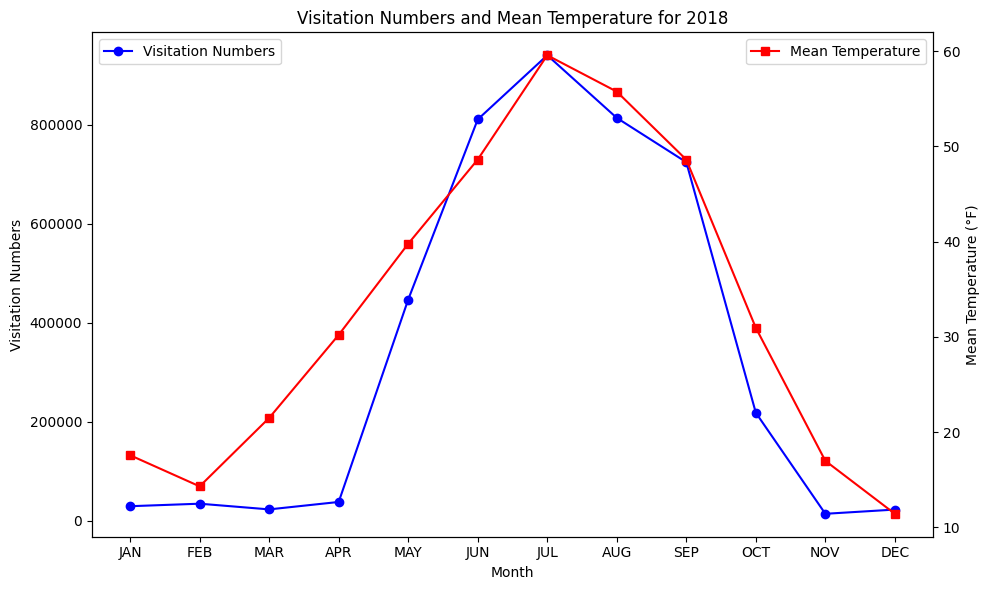

In [46]:
plot_visitation_temperature_relationship(combined_data, 2018)


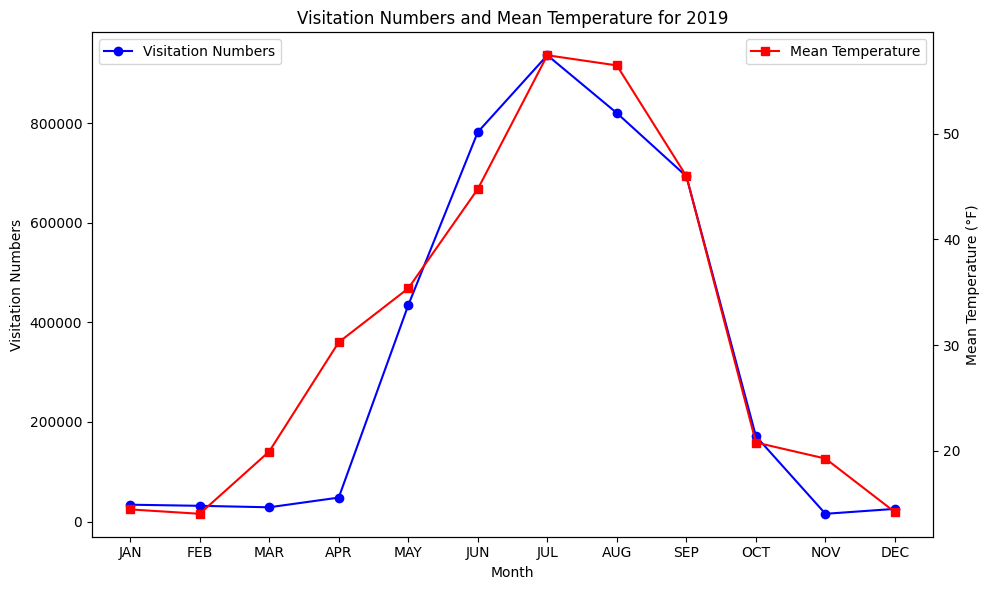

In [47]:
plot_visitation_temperature_relationship(combined_data, 2019)

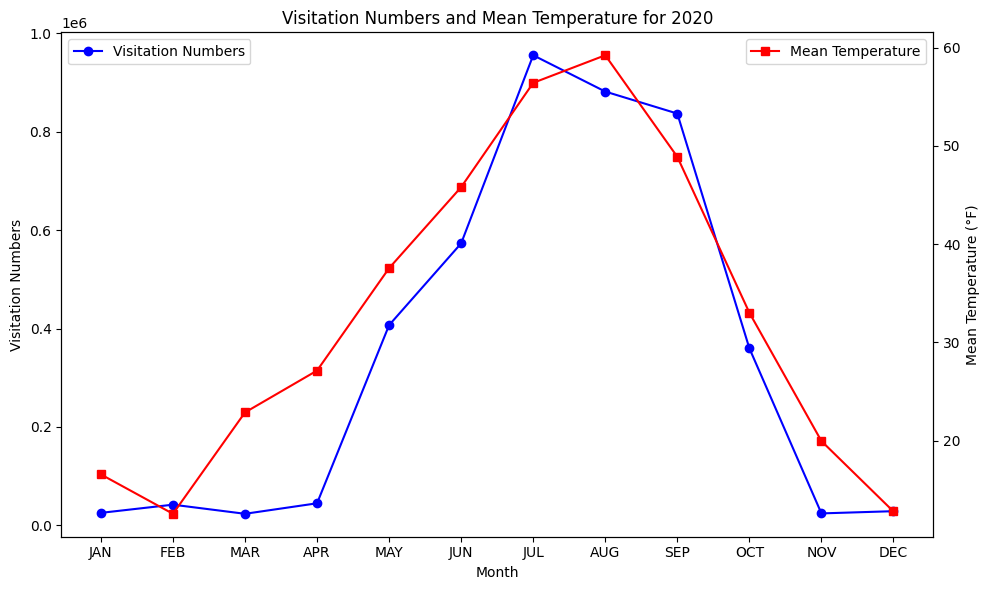

In [48]:
plot_visitation_temperature_relationship(combined_data, 2020)

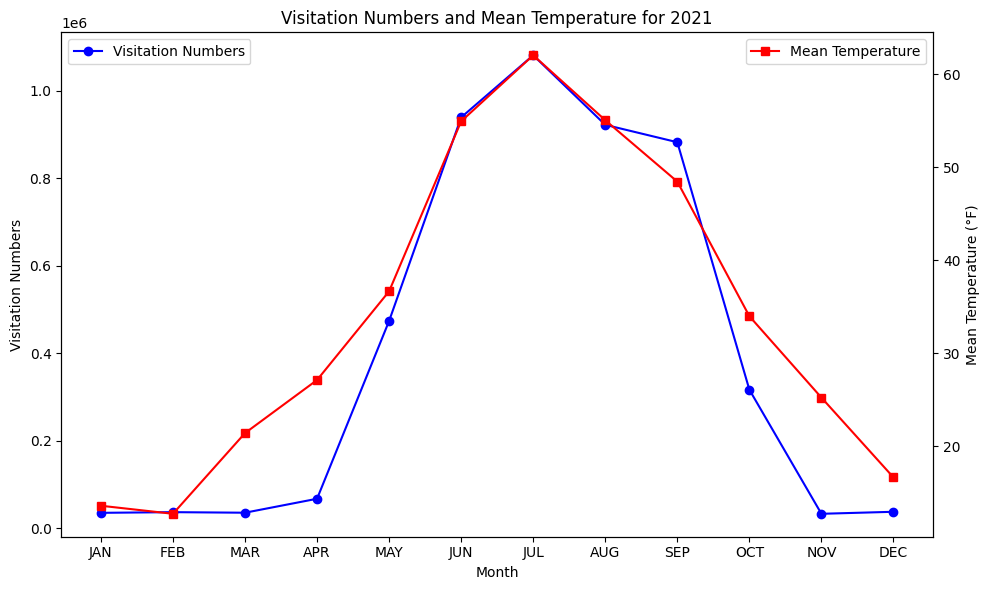

In [49]:
plot_visitation_temperature_relationship(combined_data, 2021)

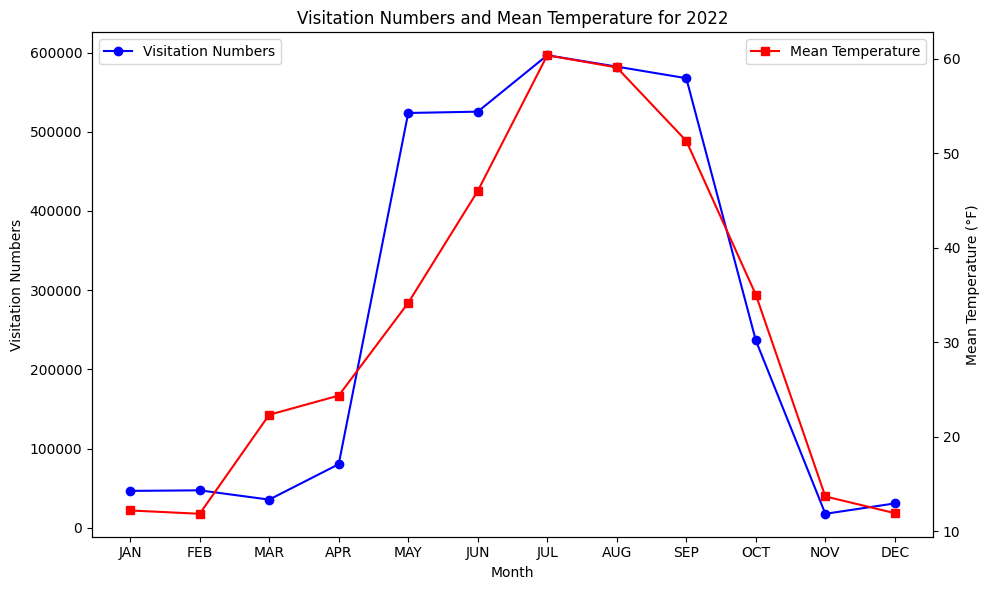

In [50]:
plot_visitation_temperature_relationship(combined_data, 2022)

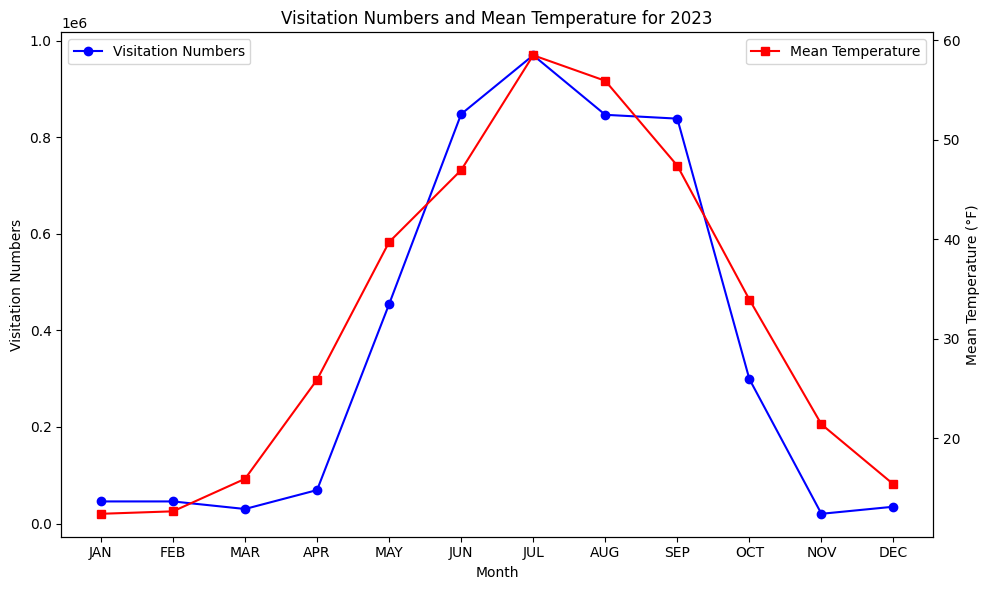

In [51]:
plot_visitation_temperature_relationship(combined_data, 2023)

As we can see from these visuals, as the average temperature rises, so does park visitation. Each year follows a similar curve with the exception of 2022 where we see a spike in visitation in May despite low temperatures.

### **5.2:** Does precipitation affect park visitation?

In [52]:
# Creating a function for a line graph showing precipitation vs visitation
def plot_visitation_precipitation_relationship(combined_data, year):
    # Filter data for the specified year
    data_year = combined_data[combined_data['Year'] == year]

    # Months and corresponding visitation numbers and average precipitation
    months = data_year['Month']
    visitation_numbers = data_year['Visitation']
    avg_precipitation = data_year['Average Precipitation']

    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting visitation numbers
    ax1.plot(months, visitation_numbers, marker='o', color='b', label='Visitation Numbers')

    # Adding second y-axis for average precipitation
    ax2 = ax1.twinx()
    ax2.plot(months, avg_precipitation, marker='s', color='g', label='Average Precipitation')

    # Set labels and title
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Visitation Numbers')
    ax2.set_ylabel('Average Precipitation (inches)')
    plt.title(f'Visitation Numbers and Average Precipitation for {year}')

    # Adding legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show plot
    plt.tight_layout()
    plt.show()

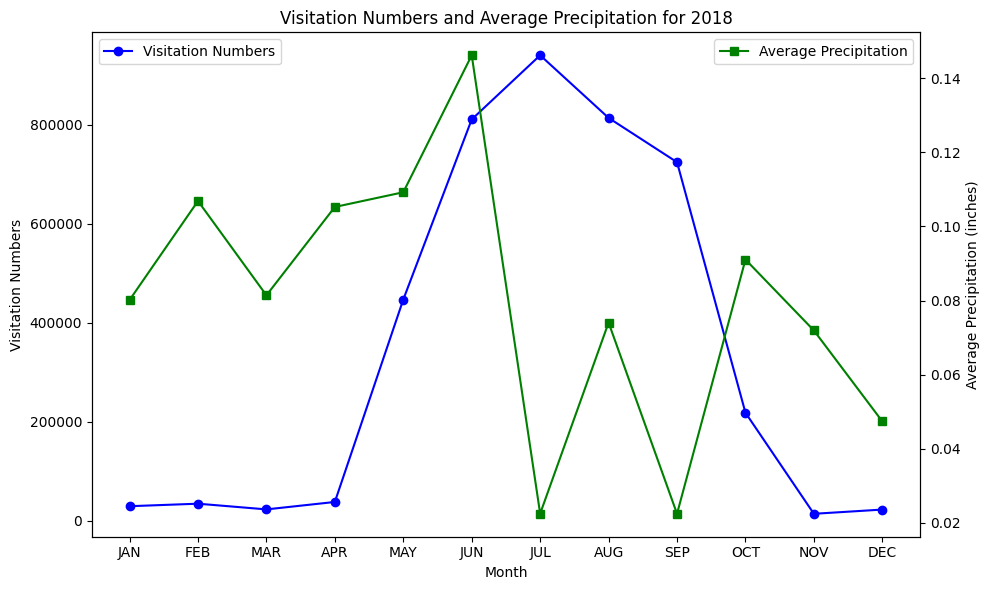

In [53]:
plot_visitation_precipitation_relationship(combined_data, 2018)

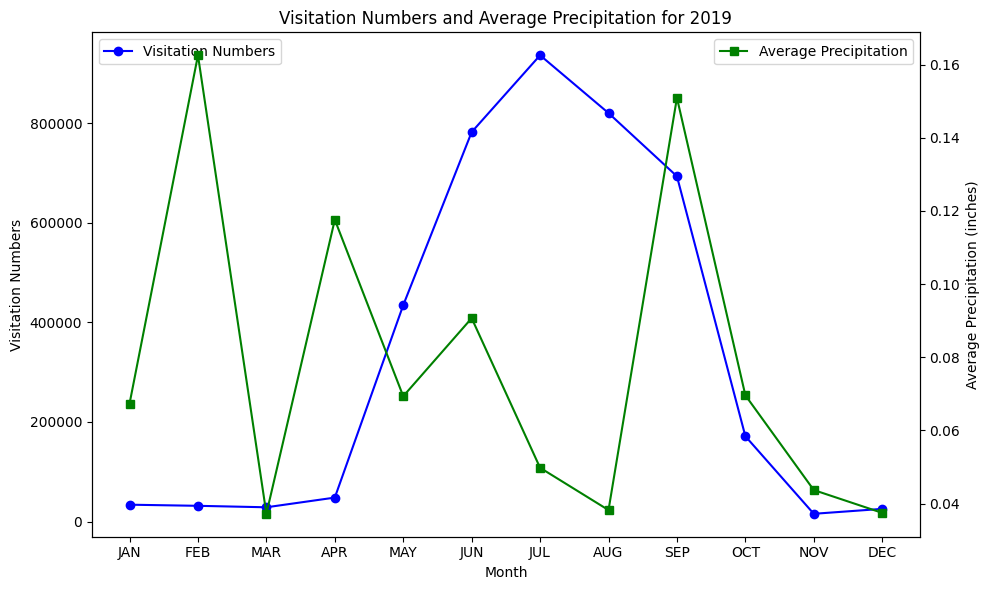

In [54]:
plot_visitation_precipitation_relationship(combined_data, 2019)

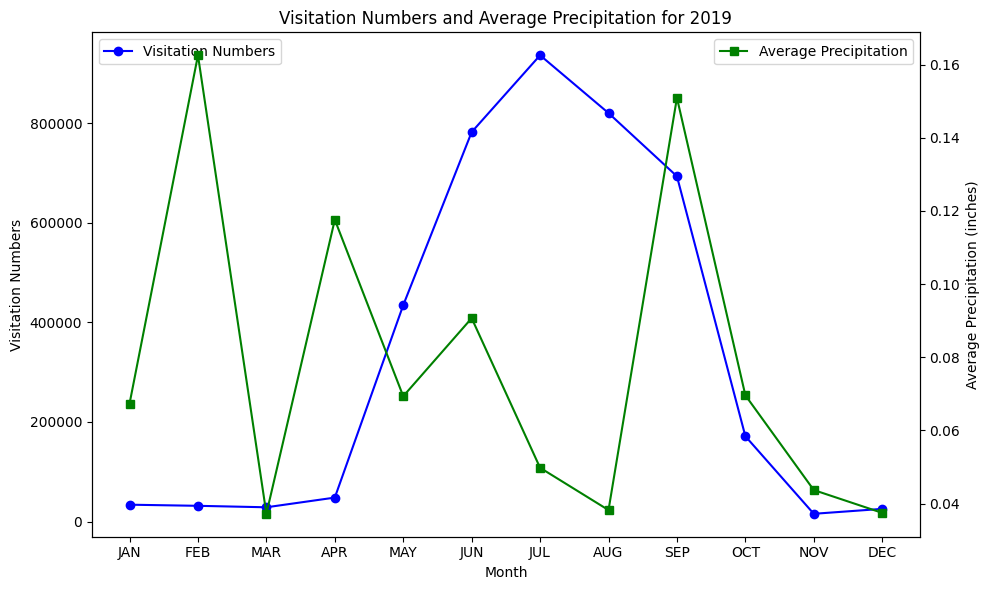

In [55]:
plot_visitation_precipitation_relationship(combined_data, 2019)

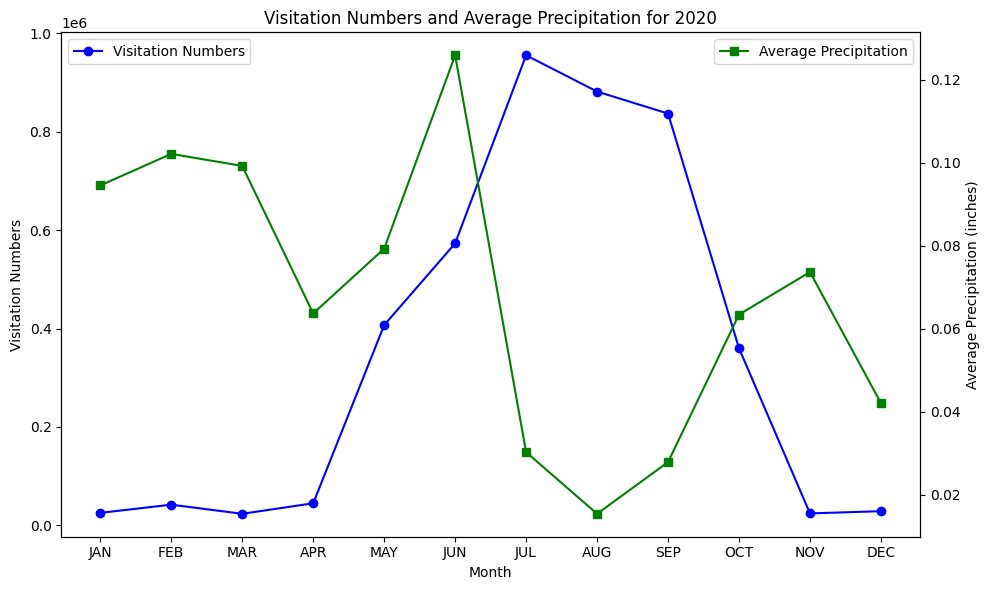

In [56]:
plot_visitation_precipitation_relationship(combined_data, 2020)

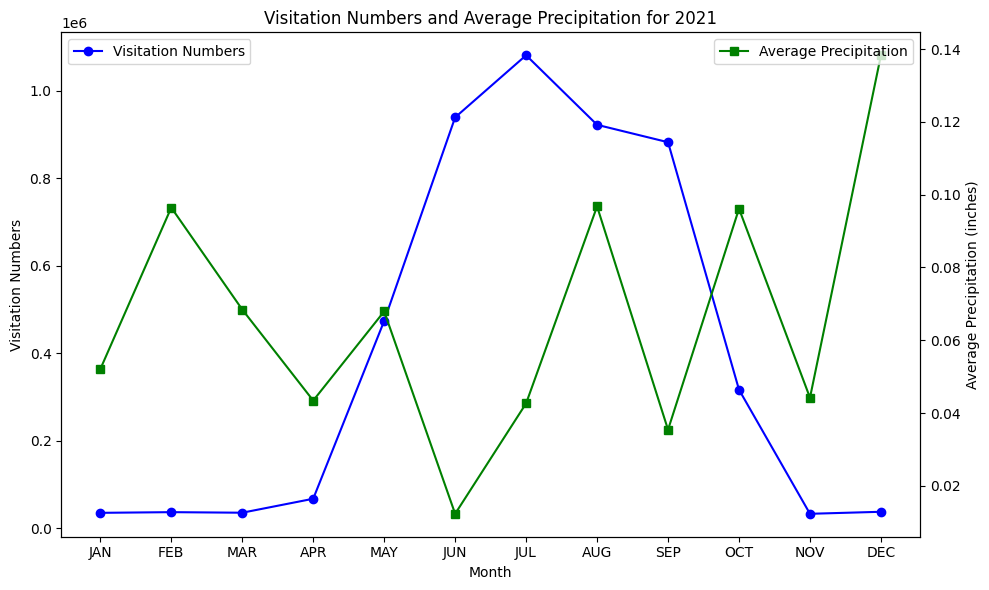

In [57]:
plot_visitation_precipitation_relationship(combined_data, 2021)

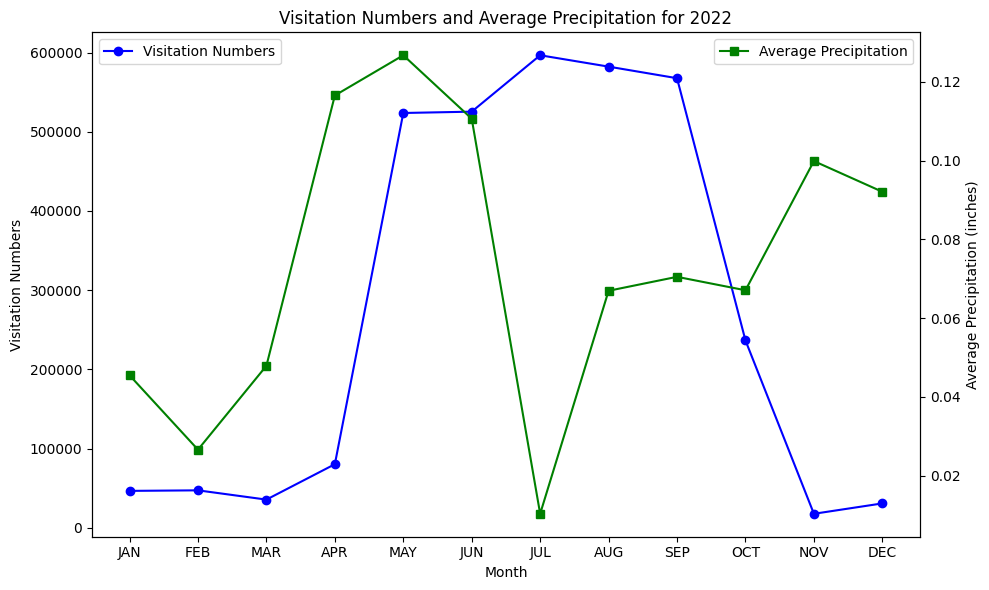

In [58]:
plot_visitation_precipitation_relationship(combined_data, 2022)

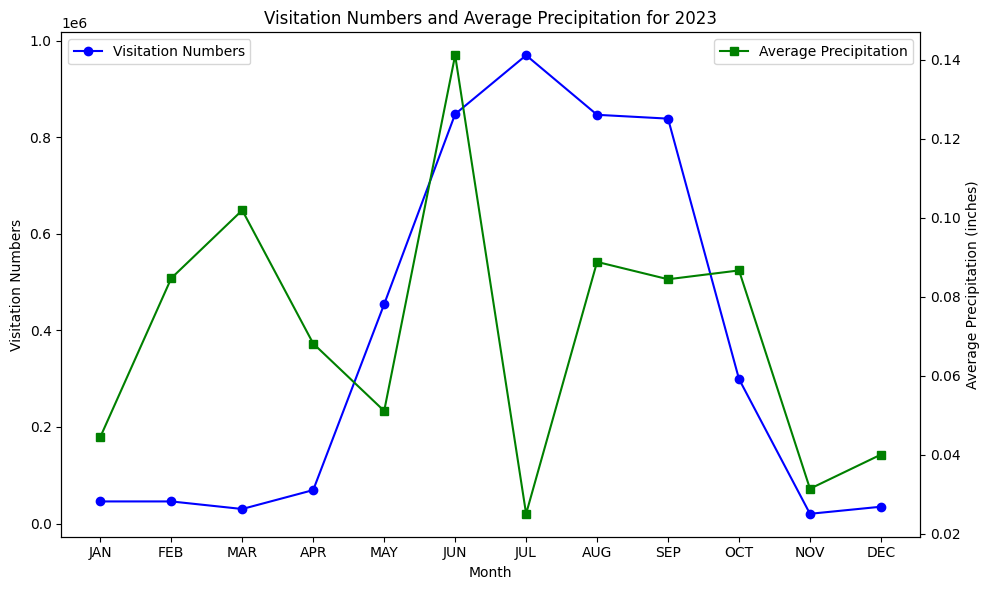

In [59]:
plot_visitation_precipitation_relationship(combined_data, 2023)

Average precipitation appears to vary greatly from year to year. There does not seem to be a relationship between precipitation averages and visitation numbers based on these graphs. For example, in June 2023 precipitation was high and so were visitor numbers. In July 2023, precipitation is low and visitation remains high. We saw previously that visitation followed a very similar curve to temperature, but the same relationship is not observed with precipitation.

### **5.3:** Reflection

With more time to work on the project, we could explore the effect of more weather variables such as wind speed. We could also explore the effect of weather on different types of visitors, such as RV campers and tent campers.

### Sources

U.S. Department of the Interior. (2020, May 13). Yellowstone will begin first phase of reopening on May 18. National Parks Service. https://www.nps.gov/yell/learn/news/20015.htm 